In [1]:
import numpy as np
import tensorflow as tf

import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

2023-01-12 10:41:40.833852: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2023-01-12 10:41:40.834113: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from maddeb.FlowVAEnet import FlowVAEnet
from maddeb.utils import listdir_fullpath
import seaborn as sns

In [3]:
linear_norm_coeff = [1000, 5000, 10000, 10000, 10000, 10000]

## Load images

In [4]:
bands = [4,5,6,7,8,9]

######## List of data samples
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d) if not f.endswith("metadata.npy")]

train_path_isolated_gal = listdir_fullpath(
    "/sps/lsst/users/bbiswas/simulations/CATSIM_10_btk_shifted_isolated_training/"
)
validation_path_isolated_gal = listdir_fullpath(
    "/sps/lsst/users/bbiswas/simulations/CATSIM_10_btk_shifted_isolated_validation/"
)

# Take 1000 images from the first file.
images = np.load(validation_path_isolated_gal[0], allow_pickle=True)

## Convernt image to linear normalization
Note that the images were non-linearly normalized before being saved. So do denormalization first.

In [5]:
isolated_images = images['isolated_gal_stamps']

Text(0.5, 1.0, 'difference')

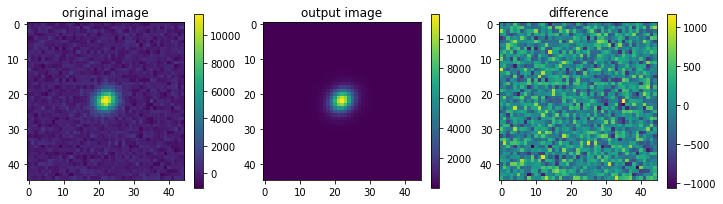

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))

image_num = 40

im = axs[0].imshow(images['blended_gal_stamps'][image_num][:, :, 2])
fig.colorbar(im, ax=axs[0], shrink=0.8)
axs[0].set_title("original image")

im = axs[1].imshow(images['isolated_gal_stamps'][image_num][:, :, 2])
fig.colorbar(im, ax=axs[1], shrink=0.8)
axs[1].set_title("output image")


difference = images['blended_gal_stamps'][image_num][:, :, 2] - images['isolated_gal_stamps'][image_num][:, :, 2]
im = axs[2].imshow(difference)
fig.colorbar(im, ax=axs[2],shrink=0.8)
axs[2].set_title("difference")

In [7]:
images_isolated_normed = np.array(np.array(images['isolated_gal_stamps'].tolist()))/linear_norm_coeff
#images_isolated_normed = np.transpose(images_isolated_normed, axes=(0, 2, 3, 1))

images_blended_normed = np.array(np.array(images['blended_gal_stamps'].tolist()))/linear_norm_coeff
#images_blended_normed = np.transpose(images_blended_normed, axes=(0, 2, 3, 1))

## Load trained models

In [8]:
from maddeb.utils import get_data_dir_path

data_dir = get_data_dir_path()

tf.get_logger().setLevel('ERROR')
latent_dim = 16
flow_net = FlowVAEnet(latent_dim=latent_dim)
flow_net.load_flow_weights(weights_path=os.path.join(data_dir, f"catsim_nonuni_shifted_lk{latent_dim}d/flow/val_loss"))
flow_net.load_vae_weights(weights_path=os.path.join(data_dir, f"catsim_nonuni_shifted_lk{latent_dim}d/vae/val_loss"))
flow_net.vae_model.trainable=False
print(flow_net.vae_model.summary())

2023-01-12 10:42:05.310264: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2023-01-12 10:42:05.310443: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-12 10:42:05.310588: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2023-01-12 10:42:05.312254: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 10:42:05.3

0.001


2023-01-12 10:42:13.431728: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 45, 45, 6)]       0         
_________________________________________________________________
encoder (Functional)         (None, 152)               7030296   
_________________________________________________________________
latent_space (MultivariateNo ((None, 16), (None, 16))  0         
_________________________________________________________________
decoder (Functional)         (None, 45, 45, 6)         4966790   
Total params: 11,997,086
Trainable params: 0
Non-trainable params: 11,997,086
_________________________________________________________________
None


# Section 1: Test the VAE

### Section 1.1 reconstructions.
If the VAE is able to correctly reconstruct images, we can conclude that the decoder can be used as a generative model

In [9]:
tf.get_logger().setLevel('ERROR')
model_vae_output_isolated = flow_net.vae_model(images_blended_normed)
model_vae_output_isolated = model_vae_output_isolated.mean()

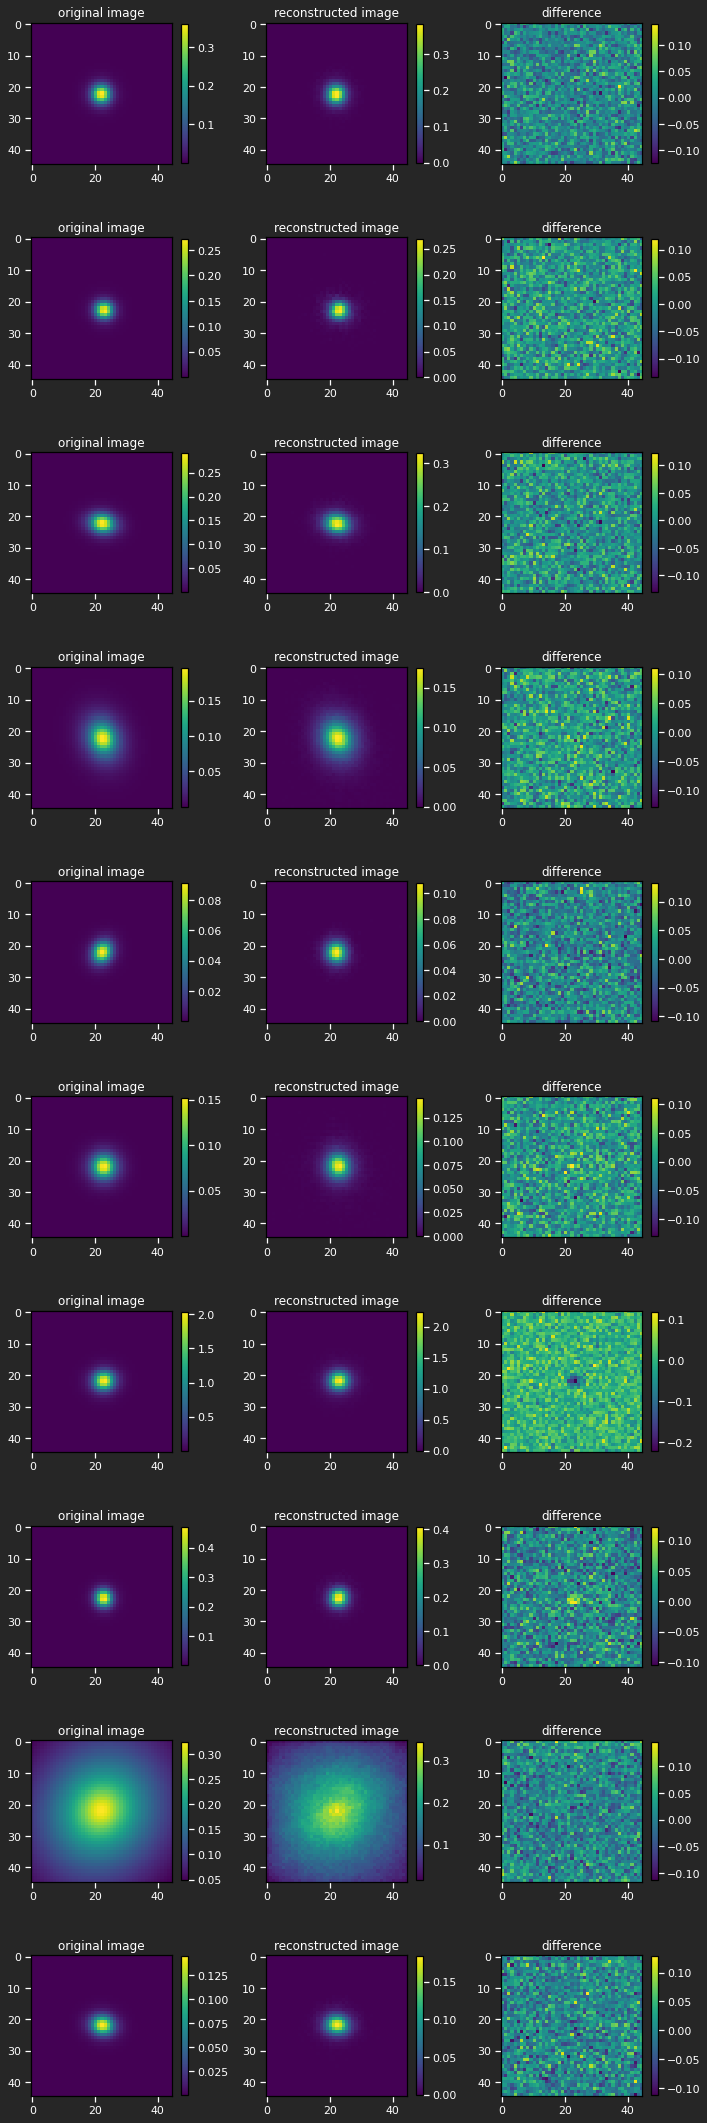

In [10]:
sns.set_theme(style={"axes.grid": False,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})

fig, axs = plt.subplots(10, 3, figsize=(10,30))

for i in range(10):
    
    image_num = i+60
    band_num = 2
    im = axs[i, 0].imshow(images_isolated_normed[image_num][:, :, band_num])
    fig.colorbar(im, ax=axs[i, 0], shrink=0.8)
    axs[i, 0].set_title("original image")

    im = axs[i, 1].imshow(model_vae_output_isolated.numpy()[image_num][ :, :, band_num])
    fig.colorbar(im, ax=axs[i, 1], shrink=0.8)
    axs[i, 1].set_title("reconstructed image")


    difference = images_blended_normed[image_num][:, :, band_num] - model_vae_output_isolated.numpy()[image_num][ :, :, band_num]
    im = axs[i, 2].imshow(difference)
    fig.colorbar(im, ax=axs[i, 2],shrink=0.8)
    axs[i, 2].set_title("difference")

plt.tight_layout()

In [11]:
import tensorflow_probability as tfp
z = tfp.layers.MultivariateNormalTriL(event_size=latent_dim)(flow_net.encoder(images_isolated_normed))

Conclusion: The reconstructions of galaxies work fairly well! <br>
So the decoder can be used as a generative model by sampling from the latent space.

### Section 1.2 Latent space distribution

In this section we aim to study the latent space distribution of galaxies as learnt by the VAE

In [12]:
images = np.load(validation_path_isolated_gal[0], allow_pickle=True)

In [13]:
latent_vars = []
for i in range(10):
    images_i = np.load(validation_path_isolated_gal[i], allow_pickle=True)
    images_isolated_normed = np.array(np.array(images_i['isolated_gal_stamps'].tolist()))/linear_norm_coeff
    #images_isolated_normed = np.transpose(images_isolated_normed, axes=(0, 2, 3, 1))
    
    z = tfp.layers.MultivariateNormalTriL(event_size=latent_dim)(flow_net.encoder(images_isolated_normed))

    latent_vars.extend(list(z.sample().numpy()))
latent_vars = np.array(latent_vars)

In [14]:
latent_vars_list =[]
for i in range(latent_dim):
    latent_vars_list.append(latent_vars[:, i])

In [15]:
print(len(latent_vars_list))

16


Text(0, 0.5, 'distribution')

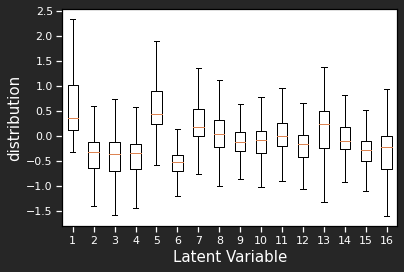

In [16]:
plt.boxplot(latent_vars_list, showfliers=False)
plt.xlabel("Latent Variable", fontsize=15)
plt.ylabel("distribution", fontsize=15)

The plot shows the distribution of the latent space variables as learnt by the VAE. <br>
In the next section we will try to see if we can model this distribution using the Normalizing Flow network. 

# Section 2. Test the flow network

### Section 2.1 Likelihood distribution

In [17]:
train_path_blended_gal = listdir_fullpath(
    "/sps/lsst/users/bbiswas/simulations/COSMOS_btk_blended_train/"
)
validation_path_blended_gal = listdir_fullpath(
    "/sps/lsst/users/bbiswas/simulations/COSMOS_btk_blended_validation/"
)
# Take 1000 images from the first file.
images_blended = np.load(validation_path_blended_gal[0], allow_pickle=True)

In [18]:
images_isolated_normed = np.array(np.array(images_blended['isolated_gal_stamps'].tolist()))/linear_norm_coeff
#images_isolated_normed = np.transpose(images_isolated_normed, axes=(0, 2, 3, 1))

images_blended_normed = np.array(np.array(images_blended['blended_gal_stamps'].tolist()))/linear_norm_coeff
#images_blended_normed = np.transpose(images_blended_normed, axes=(0, 2, 3, 1))

In [19]:
isolated_likelihood = flow_net.flow_model(images_isolated_normed)
noisy_likelihood = flow_net.flow_model(images_blended_normed)

likelihood_difference=isolated_likelihood-noisy_likelihood

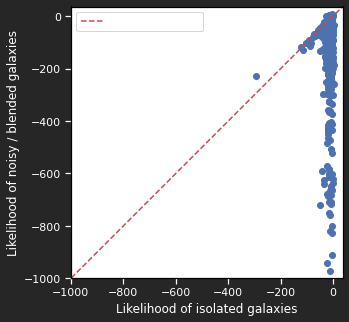

In [20]:
fig = plt.figure(figsize=(5,5))
plt.scatter(isolated_likelihood, noisy_likelihood)
max_lim = max(np.amax(isolated_likelihood), np.amax(noisy_likelihood))
min_lim = min(np.amin(isolated_likelihood), np.amin(noisy_likelihood))
plt.xlim(-1000, max_lim+30)
plt.ylim(-1000, max_lim+30)
plt.plot((min_lim, max_lim+300), (min_lim, max_lim+300), ls="--", c="r", label="equal likelihood")
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel("Likelihood of isolated galaxies", fontsize=12)
plt.ylabel("Likelihood of noisy / blended galaxies", fontsize=12)
plt.legend()

In [21]:
#plt.hist(likelihood_difference.numpy(), bins=30);

### Section 2.2 Learnt latent space distribution

Finally, let's try to see the distribution of latent variables learnt by the normalizing flow:

In [22]:
sampled_latent_vars = flow_net.td.sample(len(latent_vars_list[0])).numpy()
sampled_latent_vars_list =[]
for i in range(latent_dim):
    sampled_latent_vars_list.append(sampled_latent_vars[:, i])

In [23]:
print(len(sampled_latent_vars))

1000


On comparing the sampled latent space distribution with the actual distribution, we see by eye that the flow nework is able to learn the complex distribution in the latent space.

In [24]:
latent_value=[]
latent_var_num=[]
latent_type=[]

for i in range(latent_dim):
    latent_value.extend(list(latent_vars_list[i]))
    latent_var_num.extend([i]*len(latent_vars_list[i]))
    latent_type.extend(["actual"]*len(latent_vars_list[i]))
    
    latent_value.extend(list(sampled_latent_vars_list[i]))
    latent_var_num.extend([i]*len(sampled_latent_vars_list[i]))
    latent_type.extend(["learnt"]*len(sampled_latent_vars_list[i]))
    
df_plot ={"latent_value": latent_value, "latent_var_num":latent_var_num, "latent_type":latent_type}

In [25]:
import pandas as pd
df_plot = pd.DataFrame(df_plot)

In [26]:
df_plot

,latent_value,latent_var_num,latent_type
0,0.387083,0,actual
1,0.667098,0,actual
2,0.234885,0,actual
3,0.188764,0,actual
4,6.082935,0,actual
...,...,...,...
31995,-0.486854,15,learnt
31996,-0.283236,15,learnt
31997,-1.665631,15,learnt
31998,-0.069610,15,learnt


Text(0, 0.5, 'distribution')

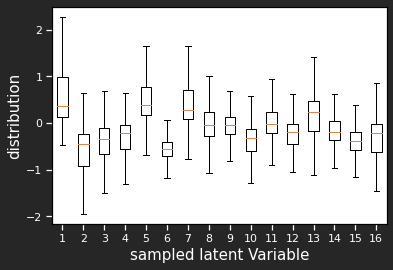

In [27]:
plt.boxplot(sampled_latent_vars_list, showfliers=False);
plt.xlabel("sampled latent Variable", fontsize=15)
plt.ylabel("distribution", fontsize=15)

In [28]:
import seaborn as sns

(-5.0, 5.0)

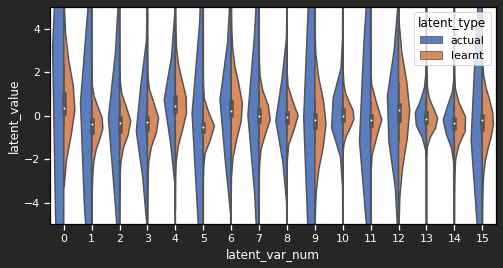

In [29]:
sns.set_theme(style={'text.color': 'black'})
f, ax = plt.subplots(figsize=(8, 4))
ax = sns.violinplot(x="latent_var_num", y="latent_value", hue="latent_type",
                    data=df_plot, palette="muted", split=True, scale="width", scale_hue=False)
ax.set_ylim(-5,5)

##### 

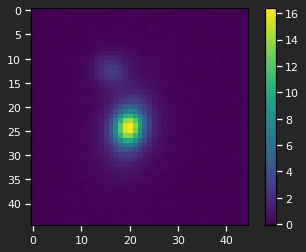

In [30]:
image_num = 30
im = plt.imshow(images_blended_normed[image_num][:, :, 2]);
ax=plt.gca()
plt.colorbar(im, ax=ax)

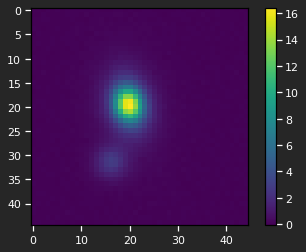

In [31]:
flipped = np.flip(images_blended_normed, axis=1)
plt.imshow(flipped[30, :, :, 2])
ax=plt.gca()
plt.colorbar(im, ax=ax)

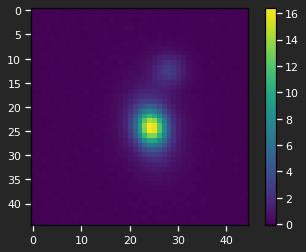

In [32]:
flipped = np.flip(images_blended_normed, axis=2)
plt.imshow(flipped[30, :, :, 2])
ax=plt.gca()
plt.colorbar(im, ax=ax)

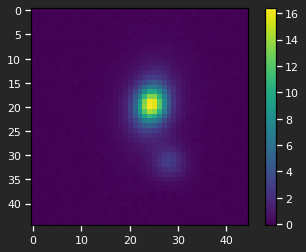

In [33]:
flipped = np.flip(np.flip(images_blended_normed, axis=1), axis=2)
plt.imshow(flipped[30, :, :, 2])
ax=plt.gca()
plt.colorbar(im, ax=ax)